In [1]:
import os
from pyspark.sql import SparkSession
import pandas as pd

import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import LabelEncoder , StandardScaler
import tensorflow as tf

from dotenv import load_dotenv
# Charger les variables d'environnement
load_dotenv()

url = os.getenv("DB_URL")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Query") \
    .config("spark.jars", "postgresql-42.6.0.jar") \
    .getOrCreate()

# Se connecter à la base de données PostgreSQL
df = spark.read \
    .format("jdbc") \
    .option("url", url) \
    .option("dbtable", "public.olympic_results") \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .load()

In [12]:
data = df.toPandas()

# Sélectionner les colonnes pertinentes
medals_data = data[['country_name', 'medal_type', 'slug_game', 'athlete_url']].dropna(subset=['medal_type'])

# Extraire l'année des jeux olympiques
medals_data['year'] = medals_data['slug_game'].str.extract(r'(\d{4})').astype(int)

# Ajouter une colonne pour le nombre d'athlètes par pays par année
medals_data['num_athletes'] = medals_data.groupby(['country_name', 'year'])['athlete_url'].transform('nunique')

# Encoder les médailles en valeurs numériques
medals_data['medal_value'] = medals_data['medal_type'].map({'GOLD': 1, 'SILVER': 1, 'BRONZE': 1})

# Regrouper les données par pays et par année
medals_by_country_year = medals_data.groupby(['country_name', 'year', 'num_athletes'])['medal_value'].sum().reset_index()

# Renommer les colonnes pour plus de clarté
medals_by_country_year.columns = ['country_name', 'year', 'num_athletes', 'total_medal_value']

# Encoder les noms de pays en valeurs numériques
label_encoder = LabelEncoder()
medals_by_country_year['country_encoded'] = label_encoder.fit_transform(medals_by_country_year['country_name'])

# Séparer les données d'entraînement et de test 
train_data = medals_by_country_year[medals_by_country_year['year'] < 2020]
test_data = medals_by_country_year[medals_by_country_year['year'] == 2020]

X_train = train_data[['country_encoded', 'year', 'num_athletes']]
y_train = train_data['total_medal_value']
X_test = test_data[['country_encoded', 'year', 'num_athletes']]
y_test = test_data['total_medal_value']


In [3]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
#Modèle Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', input_dim=3))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Initialiser Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='olympic_medals'
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
callbacks_list = [early_stopping, reduce_lr]

# Chercher les meilleurs hps
tuner.search(X_train_scaled, y_train, epochs=200, validation_split=0.2, callbacks=callbacks_list)

# Récupérer le meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 16s]
val_loss: 61.68826548258463

Best val_loss So Far: 48.550514221191406
Total elapsed time: 00h 01m 23s


In [5]:
# Entraîner le meilleur modèle
best_model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, validation_split=0.2)


Epoch 1/100
116/116 [==============================] - 0s 1ms/step - loss: 15.6327 - val_loss: 55.8627
Epoch 2/100
116/116 [==============================] - 0s 826us/step - loss: 14.4083 - val_loss: 48.5362
Epoch 3/100
116/116 [==============================] - 0s 804us/step - loss: 13.6144 - val_loss: 47.9480
Epoch 4/100
116/116 [==============================] - 0s 817us/step - loss: 14.3543 - val_loss: 49.5600
Epoch 5/100
116/116 [==============================] - 0s 839us/step - loss: 13.9950 - val_loss: 51.5005
Epoch 6/100
116/116 [==============================] - 0s 787us/step - loss: 15.3174 - val_loss: 50.2111
Epoch 7/100
116/116 [==============================] - 0s 783us/step - loss: 14.3028 - val_loss: 50.5346
Epoch 8/100
116/116 [==============================] - 0s 856us/step - loss: 14.2202 - val_loss: 52.4256
Epoch 9/100
116/116 [==============================] - 0s 900us/step - loss: 12.5925 - val_loss: 49.7426
Epoch 10/100
116/116 [==============================] - 0

In [6]:
# Sauvegarder le meilleur modèle en format HDF5
best_model.save('best_model.h5')

c:\Users\Piravin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
# Évaluer le modèle sur des données échelonnées
loss = best_model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss}')

# Faire des prédictions sur des données échelonnées
predictions = best_model.predict(X_test_scaled)

# Calculer les métriques d'évaluation
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')

3/3 [==============================] - 0s 1ms/step - loss: 9.5998
Test loss: 9.59981632232666
3/3 [==============================] - 0s 750us/step
Mean Squared Error (MSE): 9.599818905262788
Mean Absolute Error (MAE): 1.993099066518968
R-squared (R²): 0.973138711496839


In [9]:
# Convertir les prédictions et les valeurs réelles en DataFrame
comparison = pd.DataFrame({
    'Country': label_encoder.inverse_transform(X_test['country_encoded']),
    'Actual': y_test,
    'Predicted': np.squeeze(predictions)
})

# Convert entire data frame as string and print
print(comparison.to_string())




                         Country  Actual   Predicted
33                     Argentina       3    1.113360
39                       Armenia       4    5.390559
75                     Australia      45   37.018620
110                      Austria       7   10.450806
118                   Azerbaijan       7   10.413285
128                      Bahamas       2    2.562867
131                      Bahrain       1    1.633636
146                      Belarus       7    8.741713
175                      Belgium       7    7.007849
178                      Bermuda       1    1.622933
182                     Botswana       1    1.119554
202                       Brazil      20   24.970232
222                     Bulgaria       6    6.996613
223                 Burkina Faso       1    1.615391
266                       Canada      24   20.872229
285               Chinese Taipei      12   13.015276
295                     Colombia       5    6.953676
310                      Croatia       8    6.

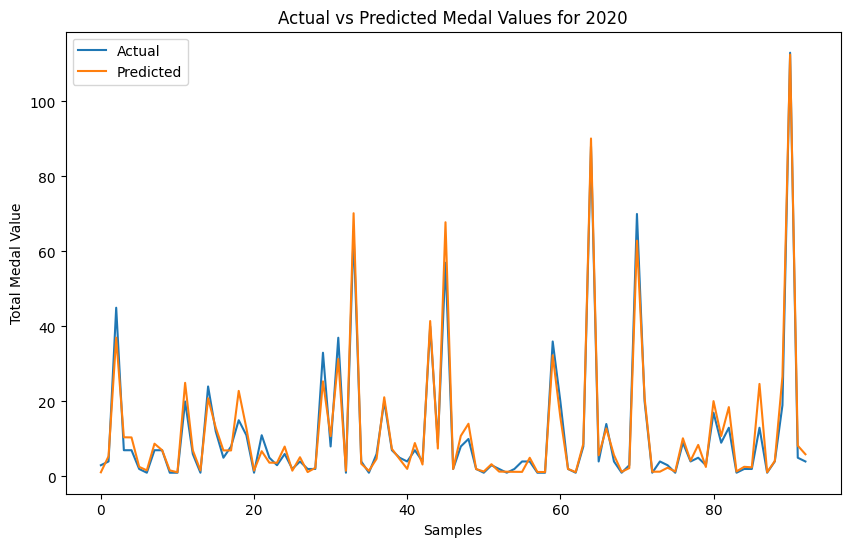

In [10]:
# Visualisation des valeurs réelles et prédites
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Total Medal Value')
plt.title('Actual vs Predicted Medal Values for 2020')
plt.show()